building grid stimsets for use with DMD. Sequence optimization is based on solution to traveling salesman problem discussed here: https://stackoverflow.com/questions/25585401/travelling-salesman-in-scipy
Thanks to the Stack Overflow community.

In [1]:
from stimset_builder import *

In [2]:
##Create a sequence of rectangular stimuli corresponding to specified grid dimension.
##Plotted in 1024x1024 'camera space' with margins that correspond to borders of DMD (manually measured and spec'd in code)
grid_stims = draw_all_grid_rects(n_cols=12, n_rows=10)

In [3]:
##make an array of center of masses
coms = image_sequence_com(grid_stims)
coms = np.array(coms)

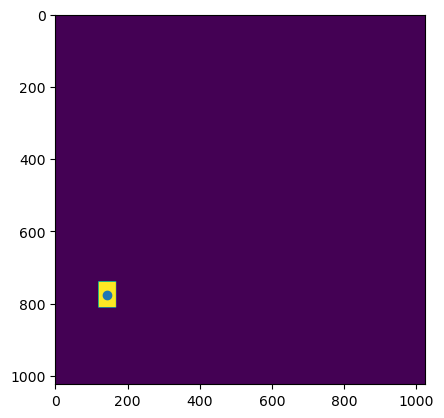

In [4]:
i=100
plt.imshow(grid_stims[:,:,i].T)
plt.scatter(coms[i][0], coms[i][1])

In [5]:
## design photostim order to minimize distance (i.e. traveling salesman)
## will not use this, except for comparison to maximized distance order
short_route = two_opt(coms,0.001)


In [6]:
route_ix=[]
for i in np.arange(len(short_route)):
    route_ix.append(list(short_route).index(i))

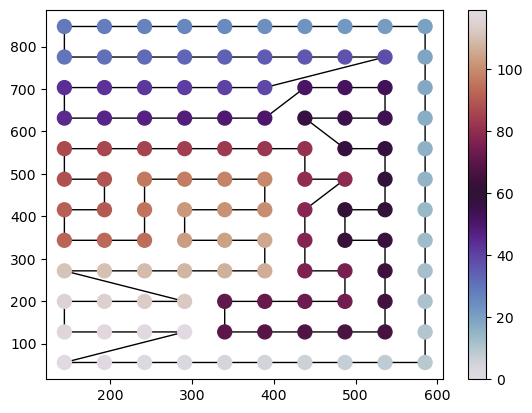

Route: [  0   1   2   3   4   5   6   7   8   9  19  29  39  49  59  69  79  89
  99 109 119 118 117 116 115 114 113 112 111 110 100 101 102 103 104 105
 106 107 108  95  94  93  92  91  90  80  81  82  83  84  85  96  97  98
  88  87  86  77  78  68  58  57  47  48  38  28  18  17  16  15  14  24
  25  26  27  37  36  46  56  67  66  76  75  74  73  72  71  70  60  61
  51  50  40  41  42  52  62  63  64  65  55  54  53  43  44  45  35  34
  33  32  31  30  23  22  21  20  10  11  12  13]

Distance: 7120.332739602971


In [7]:
new_route_order = np.concatenate((np.array([coms[short_route[i]] for i in range(len(short_route))]),np.array([coms[0]])))
fig, ax = plt.subplots()
sc = ax.scatter(coms[:,0],coms[:,1], c=route_ix, cmap='twilight', zorder=5, s=100)
# Plot the path.
ax.plot(new_route_order[:,0],new_route_order[:,1], zorder=0, c='black', lw=1)
fig.colorbar(sc)
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(short_route) + "\n\nDistance: " + str(path_distance(short_route,coms)))

In [8]:
long_route = two_opt_long(coms,0.0001)

In [9]:
route_ix=[]
for i in np.arange(len(long_route)):
    route_ix.append(list(long_route).index(i))

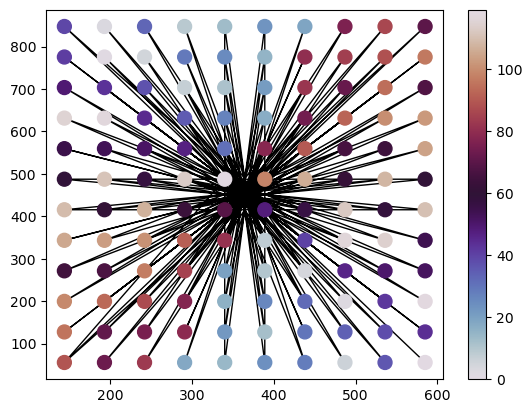

Route: [  9 101  27 111  36 102   7  93  45 113  35  94  15 114   4 105  24  85
   3 116  34  95  14 115   5 104  25  84   6 103  16  74  26 112  17  83
   8  92  18 110  46 100  28  91  19  82  37  73  55  90  38  72  39  71
  49  70  56  62  58  60  69  51  67  53  78  30  77  31  99  54 119  11
  97   1  86  12 117  23  75  13 106  44  96   2 107  33 118  22 108   0
  76  43  87  21  98  10 109  32  65  20  88  42  89  41  79  40  66  52
  68  50  59  61  57  63  48  80  47  81  29  64]

Distance: 63391.19478178264


In [10]:
new_route_order = np.concatenate((np.array([coms[long_route[i]] for i in range(len(long_route))]),np.array([coms[0]])))
fig, ax = plt.subplots()
sc = ax.scatter(coms[:,0],coms[:,1], c=route_ix, cmap='twilight', zorder=5, s=100)
# Plot the path.
ax.plot(new_route_order[:,0],new_route_order[:,1], zorder=0, c='black', lw=1)
fig.colorbar(sc)
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(long_route) + "\n\nDistance: " + str(path_distance(long_route,coms)))

In [11]:
##have not explicitly avoided having adjacent pixels in long route. May add in future. See how did by comparing min. distances.
min_dist_short_route = np.min(distances_all_steps(short_route, coms))
min_dist_long_route = np.min(distances_all_steps(long_route, coms))
print ("min dist short path: %s pixels", (min_dist_short_route))
print ("min dist long path: %s pixels", (min_dist_long_route))

min dist short path: %s pixels 49.0
min dist long path: %s pixels 174.18381095842403


In [12]:
sequence_dict = {}
sequence_dict['raster'] = np.arange(len(long_route))
sequence_dict['long_path'] = long_route
sequence_dict['default'] = long_route

In [13]:
grid_12by10 = StimSequenceSet(grid_stims, "grid_12by10", sequence_dict)

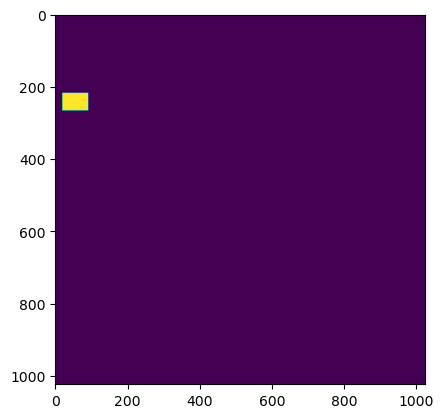

In [14]:
plt.imshow(grid_12by10.get_single_image([2]))

In [15]:
long_path_seq = grid_12by10.get_default_seq()

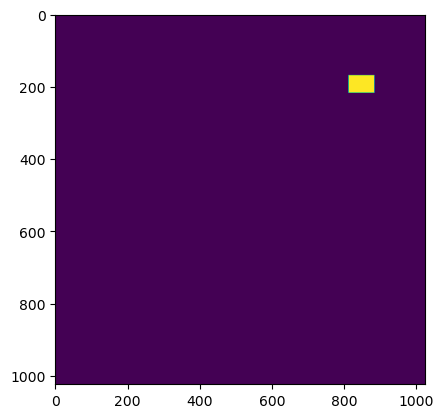

In [16]:
i=3
plt.imshow(long_path_seq[:,:,i])

In [17]:
import pickle

In [18]:
with open(f'grid_12by10.pickle', 'wb') as file:
    pickle.dump(grid_12by10, file) 

In [19]:
with open(f'grid_12by10.pickle', 'rb') as file2:
    grid_new = pickle.load(file2)

In [20]:
grid_new.name

'grid_12by10'

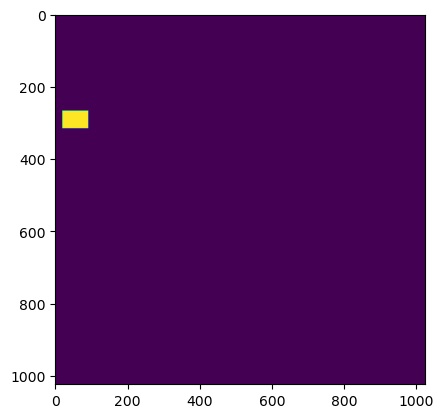

In [21]:
stim_pats = grid_new.image_sequence
plt.imshow(stim_pats[:,:,3])

In [22]:
coarse_grid = draw_all_grid_rects(n_cols=6, n_rows=5)

In [23]:
coms = image_sequence_com(coarse_grid)
coms = np.array(coms)

In [24]:
long_route = two_opt_long(coms,0.0001)

In [25]:
route_ix=[]
for i in np.arange(len(long_route)):
    route_ix.append(list(long_route).index(i))

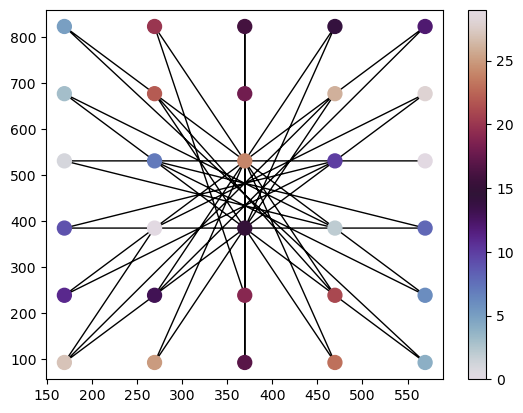

Route: [19 15 13 20  4 25  9 16 14 10 18  5 29  6 28 12 27  2 22  7 26  8 21  3
 17  1 23  0 24 11]

Distance: 15867.061967288835


In [26]:
new_route_order = np.concatenate((np.array([coms[long_route[i]] for i in range(len(long_route))]),np.array([coms[0]])))
fig, ax = plt.subplots()
sc = ax.scatter(coms[:,0],coms[:,1], c=route_ix, cmap='twilight', zorder=5, s=100)
# Plot the path.
ax.plot(new_route_order[:,0],new_route_order[:,1], zorder=0, c='black', lw=1)
fig.colorbar(sc)
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(long_route) + "\n\nDistance: " + str(path_distance(long_route,coms)))

In [27]:
sequence_dict = {}
sequence_dict['raster'] = np.arange(len(long_route))
sequence_dict['long_path'] = long_route
sequence_dict['default'] = long_route

In [28]:
grid_6by5 = StimSequenceSet(coarse_grid, "grid_6by5", sequence_dict)

In [29]:
with open(f'grid_6by5.pickle', 'wb') as file:
    pickle.dump(grid_6by5, file) 